In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image, ImageDraw, ImageFont

import gzip
import os
import json
import re

In [2]:
from PIL import Image, ImageDraw, ImageFont

# draw = ImageDraw.Draw('../cloned/Resume-Job-Description-Matching/distance.png')
image = Image.open('../cloned/Resume-Job-Description-Matching/distance.png')
draw = ImageDraw.Draw(image)
# use a bitmap font
# font = ImageFont.truetype("Roboto-BlackItalic.ttf")

# draw.text((10, 10), "hello", font=font)

# use a truetype font
font = ImageFont.truetype("Roboto-BlackItalic.ttf", 15)

draw.text((10, 25), "world", font=font)

In [3]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import split_on_space
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_punctuation


def clean_strings(data):
    # stop_words = load_stopwords('mallet_en_stoplist.txt')
    data = remove_stopwords(data)
    data = strip_multiple_whitespaces(data)
    data = strip_non_alphanum(data)
    data = strip_punctuation(data)
    data = split_on_space(data.lower())
    return data

In [4]:
def filter_punctuation(tokens):
    punct = string.punctuation
    return [word   for word in tokens   if word not in punct ]

In [5]:
def read_and_clean_jds(infile):
    print("\nReading and cleaning text from {}".format(infile))
    jds = []
    categories = []
    with gzip.open(infile,'rt') as f:
        for line in tqdm(f):
            json_line = ''
            try:
                json_line = json.loads(line)
            except:
                print("An execption occurred loading the following line")
                print(line)
                next
            category = json_line['category']
            category = re.sub(r'\/','_',category)
            jd = json_line['job_description']
            jd_text = jd.translate(str.maketrans('','',string.punctuation))
            jd_text = re.sub(r'\s+', ' ', jd_text)
            # jd_tokens = filter_punctuation(word_tokenize(jd_text.lower()))
            jd_tokens = clean_strings(jd_text)
            category_text = re.sub(r'\s+', '_', category)
            categories.append(category_text.lower())
            jds.append(jd_tokens)
            
    return jds, categories

In [33]:
job_description_data = 'indeed_job_posting.ldjson.gz'
jds, categories = read_and_clean_jds(job_description_data)
jds_text = [ ' '.join(jd) for jd in jds ]
np_cat = np.array(categories)
print(dict(Counter(categories)))
print(len(np.unique(np_cat)))
# jds, categories = read_and_clean_jds()
df = pd.DataFrame(list(zip(categories, jds_text)), columns=['category', 'job_description'])
df.head()

96it [00:00, 957.31it/s]


Reading and cleaning text from indeed_job_posting.ldjson.gz


29928it [00:27, 1093.37it/s]


{'arts_entertainment_publishing': 274, 'construction_facilities': 2227, 'sales': 1946, 'healthcare': 3647, 'manufacturing_mechanical': 2250, 'engineering_architecture': 1029, 'computer_internet': 2183, 'government_military': 99, 'administrative': 3576, 'accounting_finance': 1036, 'retail': 1125, 'customer_service': 1414, 'human_resources': 672, 'upper_management_consulting': 680, 'transportation_logistics': 1853, 'real_estate': 183, 'restaurant_food_service': 1722, 'marketing_advertising_pr': 637, 'education_training': 949, 'telecommunications': 182, 'non-profit_volunteering': 364, 'hospitality_travel': 327, 'law_enforcement_security': 318, 'banking_loans': 470, 'legal': 228, 'pharmaceutical_bio-tech': 204, 'insurance': 333}
27


,category,job_description
0,arts_entertainment_publishing,graphic designer since 2011 davis management g...
1,construction_facilities,the humane society southwest washington commit...
2,sales,who we are rodeo cpg actionbased services advi...
3,healthcare,overview use nursing skills difference hospice...
4,manufacturing_mechanical,all star auto reconditioning searching experie...


<AxesSubplot:>

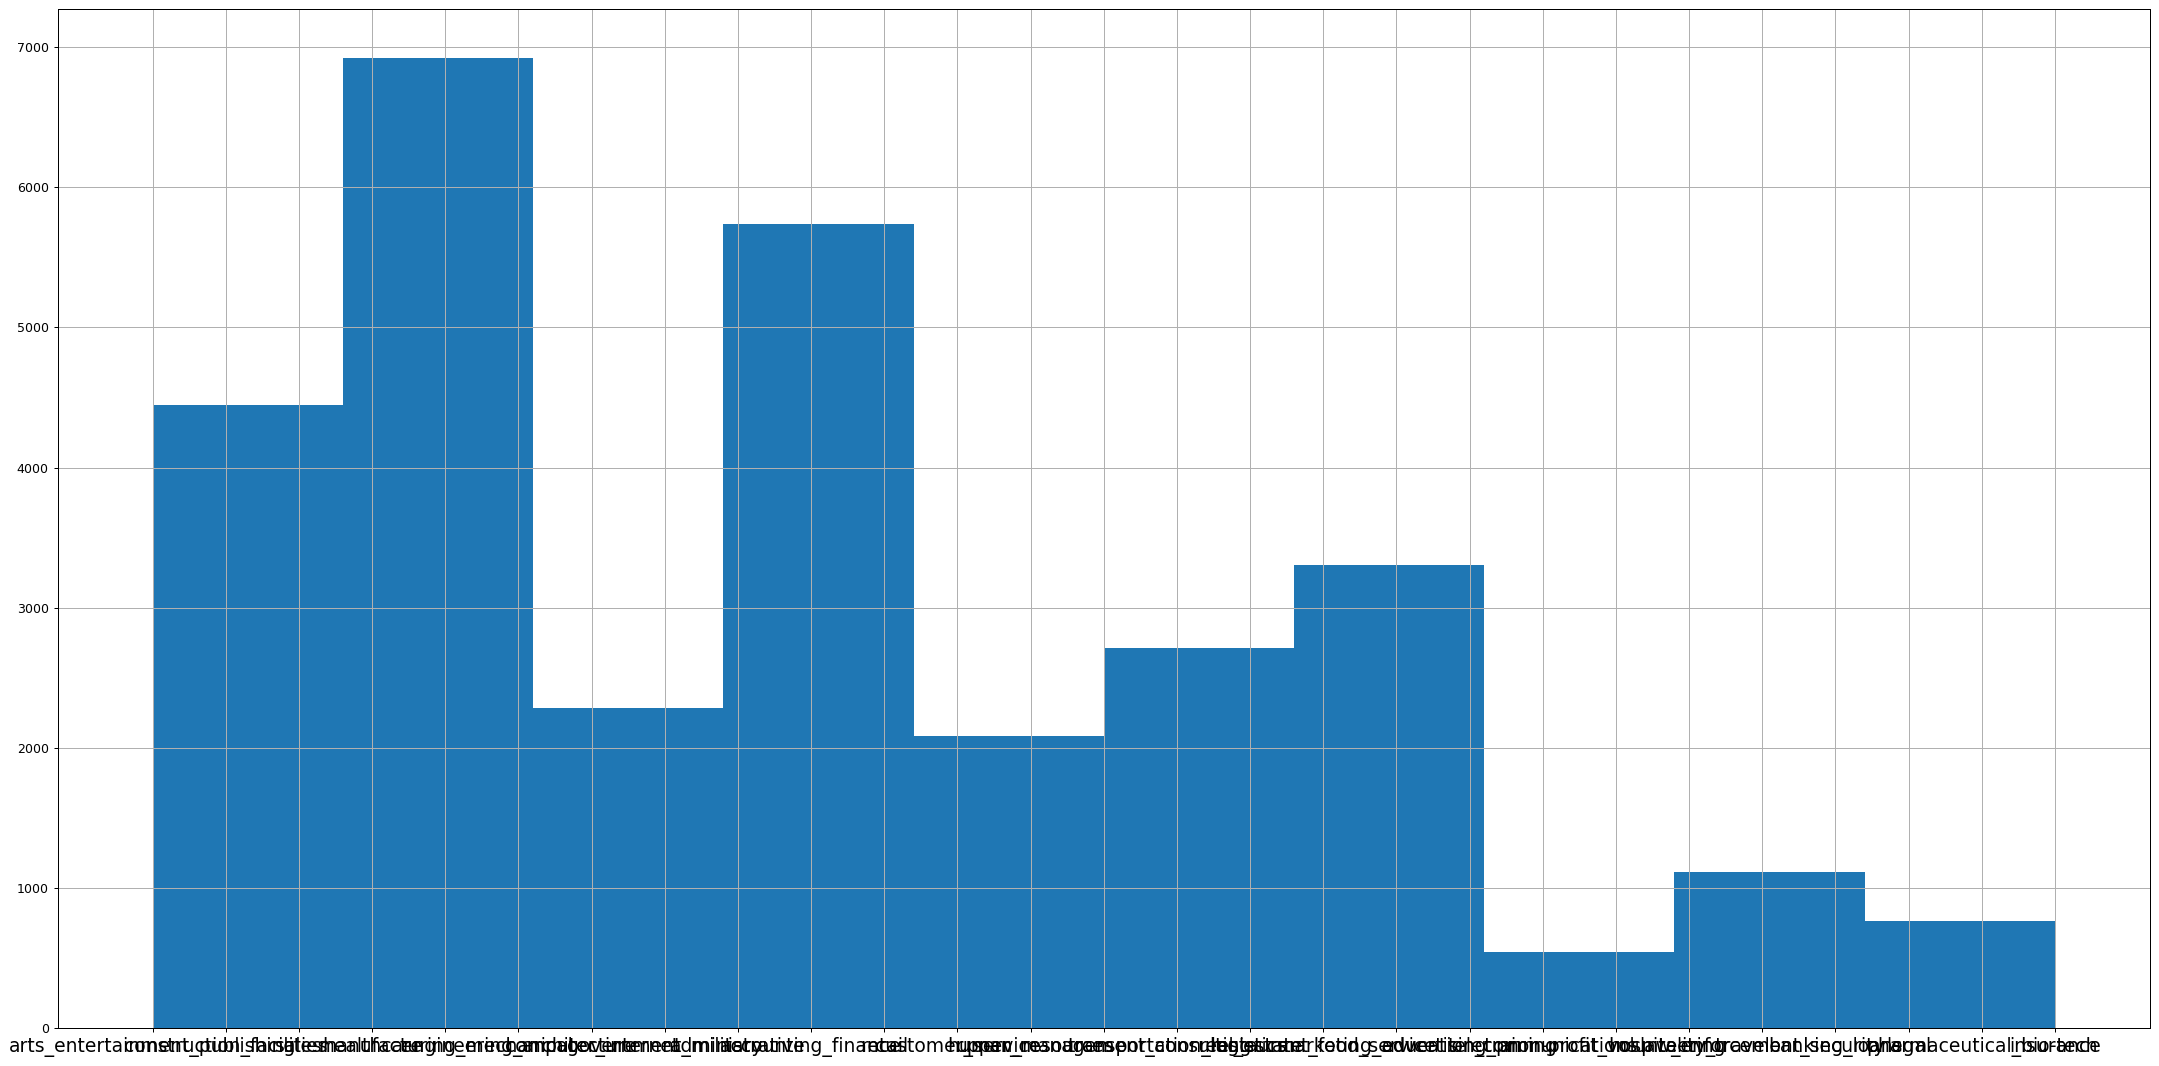

In [34]:
fig = plt.figure(figsize=(30,15), dpi=90, facecolor='w', edgecolor='k')
df.category.hist(xlabelsize=15)

In [35]:
## Lower case
df['job_description'] = df['job_description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
df['job_description'] = df['job_description'].str.replace('[^\w\s]',' ')
## digits
df['job_description'] = df['job_description'].str.replace('\d+', '')

#remove stop words
stop = stopwords.words('english')
df['job_description'] = df['job_description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
df['job_description'] = df['job_description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(df.head())

/var/folders/m2/by5fqy4n4p3_16qd9qmd31mr0000gn/T/ipykernel_75954/4212764184.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['job_description'] = df['job_description'].str.replace('[^\w\s]',' ')
/var/folders/m2/by5fqy4n4p3_16qd9qmd31mr0000gn/T/ipykernel_75954/4212764184.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['job_description'] = df['job_description'].str.replace('\d+', '')


Preprocessed data: 

                        category  \
0  arts_entertainment_publishing   
1        construction_facilities   
2                          sales   
3                     healthcare   
4       manufacturing_mechanical   

                                     job_description  
0  graphic designer since davis management group ...  
1  humane society southwest washington committed ...  
2  rodeo cpg actionbased service advisory firm de...  
3  overview use nursing skill difference hospice ...  
4  star auto reconditioning searching experienced...  


In [36]:
jda = df.groupby(['category']).sum().reset_index()
print("Agregated job descriptions: \n")
print(jda)

Agregated job descriptions: 

                         category  \
0              accounting_finance   
1                  administrative   
2   arts_entertainment_publishing   
3                   banking_loans   
4               computer_internet   
5         construction_facilities   
6                customer_service   
7              education_training   
8        engineering_architecture   
9             government_military   
10                     healthcare   
11             hospitality_travel   
12                human_resources   
13                      insurance   
14       law_enforcement_security   
15                          legal   
16       manufacturing_mechanical   
17       marketing_advertising_pr   
18        non-profit_volunteering   
19        pharmaceutical_bio-tech   
20                    real_estate   
21        restaurant_food_service   
22                         retail   
23                          sales   
24             telecommunications   
25      

In [ ]:
?WordCloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
wc = WordCloud(background_color='gray', colormap='Reds', random_state=1).generate("text is here text is there and me and her")


In [ ]:
# Start with one review:
text = "to the main door hellow thererer ererer wejrwlkejr wlekjrlwekjr wlekrk ot the to the to the"
font = ImageFont.truetype("Roboto-BlackItalic.ttf", 15)
# Create and generate a word cloud image:
wordcloud = WordCloud(font_path='Roboto-BlackItalic.ttf').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


*** accounting_finance ***



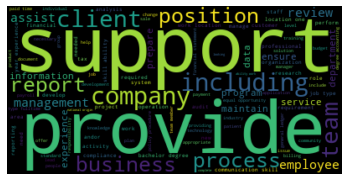


*** administrative ***



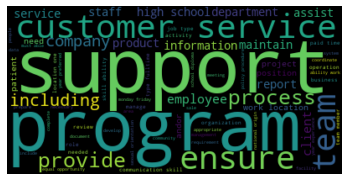


*** arts_entertainment_publishing ***



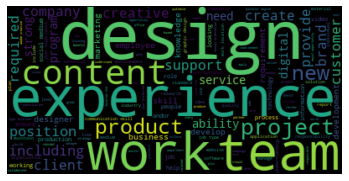


*** banking_loans ***



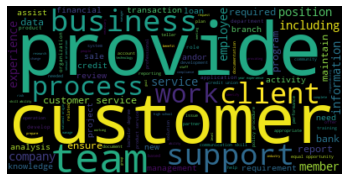


*** computer_internet ***



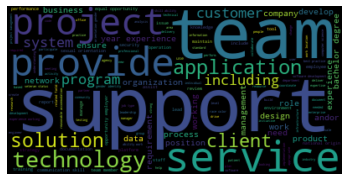


*** construction_facilities ***



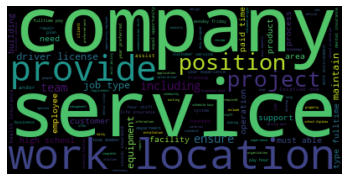


*** customer_service ***



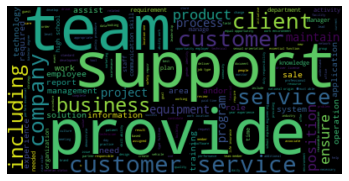


*** education_training ***



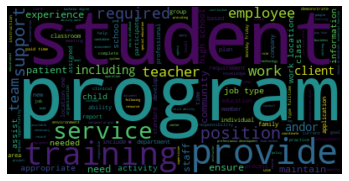


*** engineering_architecture ***



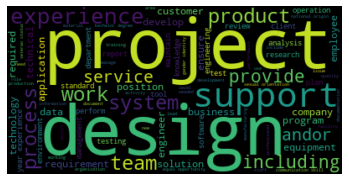


*** government_military ***



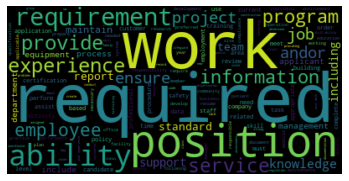


*** healthcare ***



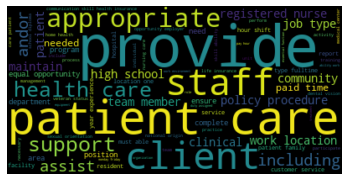


*** hospitality_travel ***



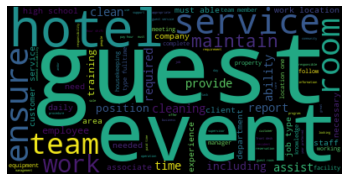


*** human_resources ***



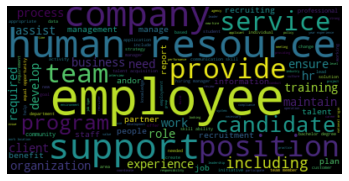


*** insurance ***



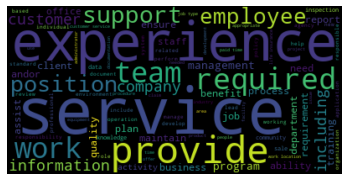


*** law_enforcement_security ***



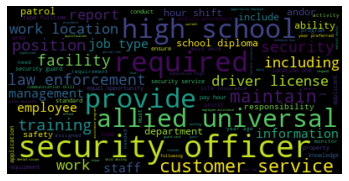


*** legal ***



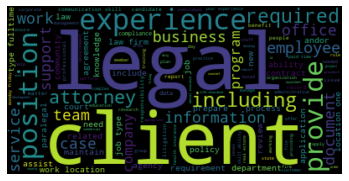


*** manufacturing_mechanical ***



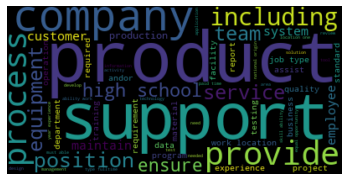


*** marketing_advertising_pr ***



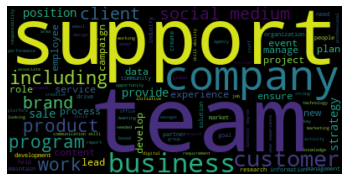


*** non-profit_volunteering ***



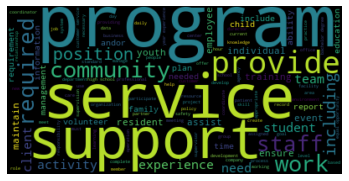


*** pharmaceutical_bio-tech ***



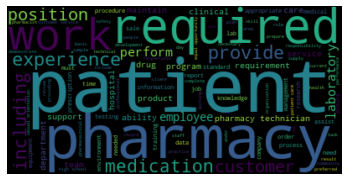


*** real_estate ***



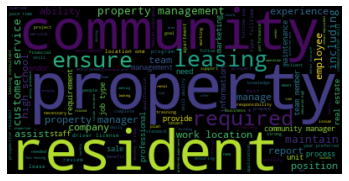


*** restaurant_food_service ***



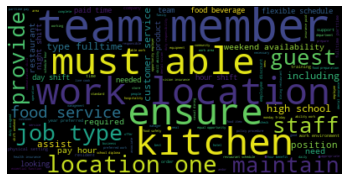


*** retail ***



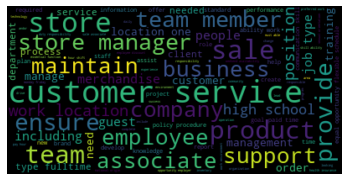


*** sales ***



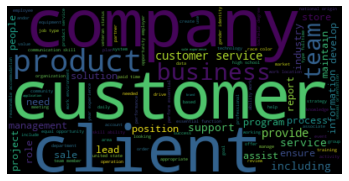


*** telecommunications ***



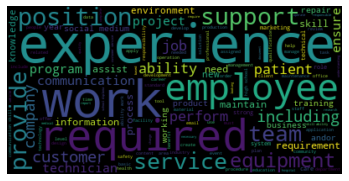


*** transportation_logistics ***



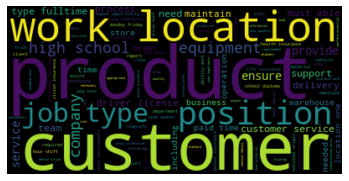


*** upper_management_consulting ***



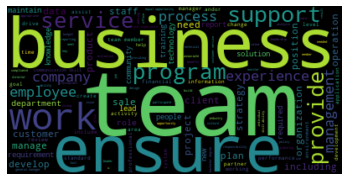

In [37]:
jobs_list = jda.category.unique().tolist()
for job in jobs_list:
    # start with one review
    text = jda[jda.category == job].iloc[0].job_description
    # print(text)
    # create and genrate a word cloud image
    wordcloud = WordCloud().generate(text)
    print("\n***", job, "***\n")
    # display the genrated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [38]:
## Delete more stop words
other_stop_words = ['business', 'work','experience','customer','work','company','technique', 'requirement'
                'candidate','skill','skills','language','menu','program','plus','technology', 'job',
                'technology','organization','position','required','data','service','location', 'type', 'ensure',
                'employee','revenue','strong', 'team', 'support', 'provide', 'process', 'including']

df['job_description'] = df['job_description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

In [39]:
## converting text to features
vectorizer = TfidfVectorizer()
# tokenize and build vocabular
X = vectorizer.fit_transform(df.job_description)
y = df.category


In [41]:
# split dat into 80/20 traning/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

train data shape:  (23942, 113808)
test data shape:  (5986, 113808)


In [55]:
dict(Counter(y_train))


{'education_training': 765,
 'computer_internet': 1695,
 'healthcare': 2901,
 'construction_facilities': 1781,
 'engineering_architecture': 814,
 'retail': 893,
 'human_resources': 549,
 'restaurant_food_service': 1364,
 'manufacturing_mechanical': 1809,
 'transportation_logistics': 1486,
 'customer_service': 1128,
 'sales': 1583,
 'accounting_finance': 845,
 'marketing_advertising_pr': 523,
 'upper_management_consulting': 542,
 'administrative': 2875,
 'insurance': 260,
 'government_military': 80,
 'banking_loans': 377,
 'law_enforcement_security': 256,
 'hospitality_travel': 268,
 'telecommunications': 139,
 'legal': 184,
 'real_estate': 149,
 'arts_entertainment_publishing': 211,
 'pharmaceutical_bio-tech': 167,
 'non-profit_volunteering': 298}

In [42]:
# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)

## predict
y_predicted = clf.predict(X_test)

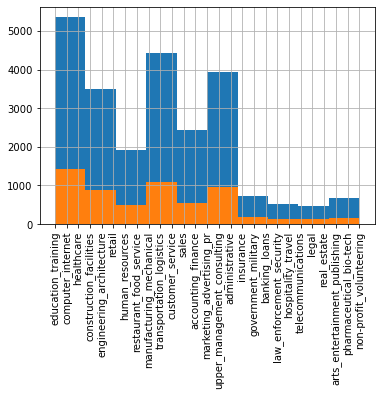

In [62]:
p = plt.hist(y_train)#.hist()
plt.xticks(rotation='vertical')
y_test.hist()
plt.show()

In [44]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.33879051119278314
Classes: (to help read Confusion Matrix)
 ['accounting_finance' 'administrative' 'arts_entertainment_publishing'
 'banking_loans' 'computer_internet' 'construction_facilities'
 'customer_service' 'education_training' 'engineering_architecture'
 'government_military' 'healthcare' 'hospitality_travel' 'human_resources'
 'insurance' 'law_enforcement_security' 'legal' 'manufacturing_mechanical'
 'marketing_advertising_pr' 'non-profit_volunteering'
 'pharmaceutical_bio-tech' 'real_estate' 'restaurant_food_service'
 'retail' 'sales' 'telecommunications' 'transportation_logistics'
 'upper_management_consulting']
Confusion Matrix: 
[[  0 162   0   0   4   0   0   0   0   0  25   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0 608   0   0  10   1   0   0   0   0  77   0   0   0   0   0   2   0
    0   0   0   2   0   1   0   0   0]
 [  0  55   0   0   6   1   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   

/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
set(y_predicted)

{'administrative',
 'computer_internet',
 'construction_facilities',
 'healthcare',
 'manufacturing_mechanical',
 'restaurant_food_service',
 'sales'}

In [45]:
set(y_predicted)

{'administrative',
 'computer_internet',
 'construction_facilities',
 'healthcare',
 'manufacturing_mechanical',
 'restaurant_food_service',
 'sales',
 'transportation_logistics'}

In [46]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)

/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.5765118610090211
Classes: (to help read Confusion Matrix)
 ['accounting_finance' 'administrative' 'arts_entertainment_publishing'
 'banking_loans' 'computer_internet' 'construction_facilities'
 'customer_service' 'education_training' 'engineering_architecture'
 'government_military' 'healthcare' 'hospitality_travel' 'human_resources'
 'insurance' 'law_enforcement_security' 'legal' 'manufacturing_mechanical'
 'marketing_advertising_pr' 'non-profit_volunteering'
 'pharmaceutical_bio-tech' 'real_estate' 'restaurant_food_service'
 'retail' 'sales' 'telecommunications' 'transportation_logistics'
 'upper_management_consulting']
Confusion Matrix: 
[[ 95  33   0   4  15   1   2   0   0   0  24   2   0   0   0   0   3   1
    0   0   0   2   0   6   0   0   3]
 [ 11 417   1   4  35  18   5  11   8   0  67   8   6   0   1   0  12   9
    2   1   0  13  28  25   0  17   2]
 [  0   3  30   0   5   6   0   3   1   0   1   0   0   0   0   0   6   6
    0   0   0   1   0   1   0

/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
set(y_test) - set(y_predicted)

{'government_military', 'telecommunications'}

In [64]:
print(clf.coef_)
print(clf.coef_.shape)
print(lr.coef_)
print(lr.coef_.shape)

[[-11.25933552 -11.56425646 -11.71337994 ... -11.71337994 -11.71337994
  -11.71337994]
 [-10.80485328 -11.69084314 -11.829879   ... -11.8742662  -11.8742662
  -11.8742662 ]
 [-11.66076907 -11.58367959 -11.66076907 ... -11.66076907 -11.66076907
  -11.66076907]
 ...
 [-11.60001384 -11.65499731 -11.65499731 ... -11.65499731 -11.65499731
  -11.65499731]
 [-11.35408429 -11.76167467 -11.76167467 ... -11.76167467 -11.76167467
  -11.76167467]
 [-11.59391547 -11.69189906 -11.69189906 ... -11.69189906 -11.69189906
  -11.69189906]]
(27, 113808)
[[ 2.83314051e-02 -8.32547526e-02 -1.07540963e-03 ... -7.34454993e-04
  -7.93937919e-04 -1.36468494e-03]
 [ 1.95765523e-01 -9.07941625e-02  2.80901334e-02 ... -5.34376230e-03
  -9.87118470e-04 -5.46778247e-03]
 [-6.73559606e-02  4.47616614e-02 -7.47204181e-04 ... -4.16396787e-04
  -3.72366717e-05 -2.09716972e-03]
 ...
 [-2.91302084e-02 -2.51188420e-02 -3.73850261e-04 ... -6.92033639e-04
  -8.63287690e-05 -5.79932190e-04]
 [-3.99320788e-02 -6.60615573e-02 -

/Users/alemgetu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [104]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
ovr = OneVsRestClassifier(LinearSVC(random_state=0), )
# x_prop = ovr.predict_proba(X_test)
ovr.fit(X_train, y_train)
x_des = ovr.decision_function(X_test)
y_predicted = ovr.predict(X_test)
# print(ovr.coef_)
# print(ovr.coef_.shape)

In [105]:
print(x_des)

[[-1.21800028 -1.26384118 -1.22417378 ... -1.35702538 -0.97789552
  -1.37785323]
 [-1.65843267 -1.59096403 -1.33450515 ... -1.49610586 -1.65428295
  -0.94243229]
 [-1.25447473 -0.0208395  -1.22832347 ... -0.92928771 -1.60085285
  -1.3776073 ]
 ...
 [-0.92032348 -1.25558981 -1.48952499 ... -1.19065646 -1.57934235
  -1.83157282]
 [-1.4530844  -0.93793402 -1.59586173 ... -1.04151119 -1.08912916
  -0.81989956]
 [-1.31548694 -0.74901816 -1.57712582 ... -1.16674135 -0.13630396
  -1.82564159]]


In [106]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", ovr.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.5688272636151019
Classes: (to help read Confusion Matrix)
 ['accounting_finance' 'administrative' 'arts_entertainment_publishing'
 'banking_loans' 'computer_internet' 'construction_facilities'
 'customer_service' 'education_training' 'engineering_architecture'
 'government_military' 'healthcare' 'hospitality_travel' 'human_resources'
 'insurance' 'law_enforcement_security' 'legal' 'manufacturing_mechanical'
 'marketing_advertising_pr' 'non-profit_volunteering'
 'pharmaceutical_bio-tech' 'real_estate' 'restaurant_food_service'
 'retail' 'sales' 'telecommunications' 'transportation_logistics'
 'upper_management_consulting']
Confusion Matrix: 
[[104  24   0   8  10   0   1   0   1   0  24   1   0   2   0   0   4   1
    0   0   0   1   2   4   0   1   3]
 [ 16 367   1   8  40  17  13   9   8   1  64   8   6   3   1   1  23  10
    3   3   0   9  24  31   0  25  10]
 [  0   2  33   0   5   3   0   3   1   0   0   1   0   0   0   0   6   5
    0   0   0   1   0   1   0

In [84]:
set(y_test) - set(y_predicted)

set()

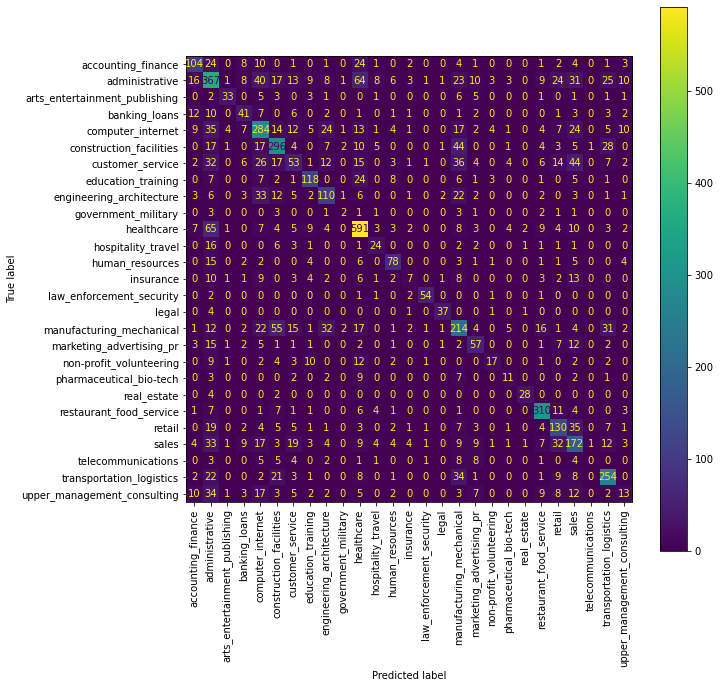

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predicted, labels=ovr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ovr.classes_)
fig, ax = plt.subplots(figsize=(10, 10))

disp.plot(xticks_rotation='vertical', ax=ax)
plt.show()

In [91]:
# print(ovr.coef_)
# print(ovr.coef_.shape)
clf.feature_log_prob_[0, :]
ovr.feature_names_in_(y_predicted)

AttributeError: 'OneVsRestClassifier' object has no attribute 'feature_names_in_'

In [101]:
x_prob = ovr.predict_proba(X_test)

AttributeError: This 'OneVsRestClassifier' has no attribute 'predict_proba'

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predicted = rf.predict(X_test)

In [ ]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", ovr.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

In [99]:
set(y_test) - set(y_predicted)

{'pharmaceutical_bio-tech', 'telecommunications'}

In [135]:
# Fit model
clf = MultinomialNB(alpha=0.001)
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

In [136]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.5175409288339459
Classes: (to help read Confusion Matrix)
 ['accounting_finance' 'administrative' 'arts_entertainment_publishing'
 'banking_loans' 'computer_internet' 'construction_facilities'
 'customer_service' 'education_training' 'engineering_architecture'
 'government_military' 'healthcare' 'hospitality_travel' 'human_resources'
 'insurance' 'law_enforcement_security' 'legal' 'manufacturing_mechanical'
 'marketing_advertising_pr' 'non-profit_volunteering'
 'pharmaceutical_bio-tech' 'real_estate' 'restaurant_food_service'
 'retail' 'sales' 'telecommunications' 'transportation_logistics'
 'upper_management_consulting']
Confusion Matrix: 
[[ 84  29   0   5  17   1   1   0   3   0  27   4   1   0   0   1   3   1
    1   0   1   1   1   4   0   0   6]
 [ 18 293   3   6  49  16   6  21  16   2  73  27   8   1   2   3  18  15
    4   2   0  19  32  29   0  23  15]
 [  0   3  27   0   7   2   1   3   2   0   0   0   0   0   0   0   6   8
    0   0   0   0   0   4   0

In [132]:
set(y_test) - set(y_predicted)

set()

In [147]:
from textblob import TextBlob
# technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn',
#                     'numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow',
#                    'linux','Ruby','JavaScript','django','react','reactjs','ai','ui','tableau']
feature_array = vectorizer.get_feature_names_out()
print(feature_array, len(feature_array))
# number of overall model features
features_numbers = len(feature_array)
## max sorted features numbers
n_max = int(features_numbers * 0.1)

## initialize output dataframe
output = pd.DataFrame()

for i in range(0, len(clf.classes_)):
    print("\n***", clf.classes_[i], "***\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(np.where(raw_skills == 'python'))
    # print(list(set(technical_skills).intersection(raw_skills)))
    # break
     ## Extract technical skills
    # top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:26]
    #print("Top technical skills",top_technical_skills)
    
    ## Extract adjectives
    
    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    #raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    #raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:6]
    #print("Top 6 adjectives: ",top_adjectives)
    
    output = output.append({'category':clf.classes_[i],
                        'soft_skills':top_adjectives },
                       ignore_index=True)

['aa' 'aaa' 'aaaa' ... 'ﬁngersticks' 'ﬂexible' 'ﬂows'] 113808

*** accounting_finance ***

list of unprocessed skills :
(array([1458]),)
['ai', 'tableau', 'spark', 'sql', 'python', 'react', 'java']


In [144]:
print(output.T)

                                                                 0   \
category                                         accounting_finance   
technical_skills     [ai, tableau, spark, sql, python, react, java]   
soft_skills       [financial, accountant, monthly, payable, rela...   

                                                                 1   \
category                                             administrative   
technical_skills       [python, ui, tableau, spark, sql, ai, react]   
soft_skills       [administrative, assistant, assist, medical, e...   

                                                                 2   \
category                              arts_entertainment_publishing   
technical_skills  [php, python, ui, spark, linux, ai, mysql, rea...   
soft_skills       [graphic, creative, digital, social, preferred...   

                                                                 3   \
category                                              banking_loans   
tec